In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import roc_auc_score
from IPython.display import Image
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns 
from matplotlib import pyplot
import requests

# Functions

In [2]:
############# Find MAPE #############

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#######################################
  
from sklearn.metrics.scorer import make_scorer

custom_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

############# Calculate Distance Between Two Points #############

def distance(origin, destination): #[lat lon] 
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    
    return d
#######################################

############# Calculate avg price within the specific area #############

def price_nearby(data, data_2):
    
    all_ave_MinSalePrice = []
    cnt = 0
    for col,row in data.iterrows():
        
        cnt = cnt + 1
        if cnt%100 == 0:
            print(cnt)
        
        Lat = row['Lat']
        Lng = row['Lng']
        ListingID = row['ListingID']
        Beds_1 = row['Beds']
        moc_data = data_2
        location_1 = [Lat, Lng]
        small_data = moc_data[moc_data.ListingID != ListingID]
        
        total_MinSalePrice = []
        for small_col, small_row in small_data.iterrows():
            Lat_2 =  small_row['Lat']
            Lng_2 =  small_row['Lng']
            MinSalePrice = small_row['MinSalePrice']
            Beds_2 = row['Beds']
            location_2 = [Lat_2, Lng_2]
            d = distance(location_1, location_2)
            diff_Beds = abs(Beds_1 - Beds_2)
            
            
            if d <= 2 and diff_Beds <= 1:
                total_MinSalePrice.append(MinSalePrice)
        
        sum_MinSalePrice = np.mean(total_MinSalePrice)
        all_ave_MinSalePrice.append(sum_MinSalePrice)
    
    data['Ave_MinSalePrice'] = all_ave_MinSalePrice
    return data

############# Find avg Price within the specific district  #############
        
def map_price_district(data, data_2):
    table = pd.DataFrame(data_2, columns=['SubDistrictNameEN','AvgDistrict'])
    all_AvgDistrict = []
    cnt = 0
    for col,row in data.iterrows():
        
        cnt = cnt + 1
        if cnt%100 == 0:
            print(cnt)
        
        SubDistrictNameEN = row['SubDistrictNameEN']
        check_table = table[table.SubDistrictNameEN == SubDistrictNameEN]
        check_table = pd.DataFrame(check_table, columns=['SubDistrictNameEN','AvgDistrict'])
        all_Avg_price = check_table['AvgDistrict'].values
        
        if len(all_Avg_price) == 0:
            all_AvgDistrict.append(np.nan)
        else:
            Avg_price = all_Avg_price[0]
            all_AvgDistrict.append(Avg_price)
        
    data['AvgDistrict'] = all_AvgDistrict
    return data

############# Find OSM Features #############
        
def find_osm(lat_in,lon_in):
    
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
    [out:json][timeout:50];
    way(around:2000.0,{lat},{lon})[highway = primary]; out tags;
    node(around:2000.0,{lat},{lon})[brand = 'Starbucks']; out tags;
    node(around:2000.0,{lat},{lon})[shop='supermarket']; out tags;
    node(around:2000.0,{lat},{lon})['public_transport' = 'stop_position']; out tags;
         """
    # around is area radius in n meters
    filled_query=overpass_query.format(lat=lat_in, lon=lon_in)
    response = requests.get(overpass_url,
                            params={'data': filled_query}, timeout=(6,8))
    
    data = response.json()
    
    return data['elements']

#######################################


############# Invert OSM feature from JSON to data table  #############

def sep_data(data):
    num_highway = 0
    num_brand = 0
    num_shop = 0
    num_public_transport = 0
    
    for i in range(len(data)):
        
        data_tags = data[i]['tags']
        if 'highway' in data_tags:
            #print('highway')
            num_highway = num_highway + 1
        if 'brand' in data_tags:
            #print('brand')
            num_brand = num_brand + 1 
        if 'shop' in data_tags:
            #print('brand')
            num_shop = num_shop + 1
        if 'public_transport' in data_tags:
            #print('public_transport')
            num_public_transport = num_public_transport + 1
    return num_highway, num_brand, num_shop, num_public_transport  

def Add_osm(data):
    
    highway = []
    brand = []
    shop = []
    transport = []
    cnt = 0
    count_no_received = 0
    for col,row in data.iterrows():
        Lat = row['Lat']
        Lng = row['Lng']
        
        cnt = cnt + 1
        if cnt%100 == 0:
            print(cnt)
        
        try:
            poi = find_osm(Lat, Lng)
        #print('No JSON Recieved',count_no_received,': Row', count, len(poi))
        except:
            poi = []
            count_no_received = count_no_received + 1
            print('No JSON Recieved',count_no_received,': Row', cnt)
            
        num_highway, num_brand, num_shop, num_public_transport = sep_data(poi)
        highway.append(num_highway)
        brand.append(num_brand)
        shop.append(num_shop)
        transport.append(num_public_transport)
        
    data['highway'] = highway
    data['Starbucks'] = brand
    data['shop.'] = shop
    data['transport'] = transport
        
    return data
    
    

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Raw Data

In [3]:
# Load training data
data = pd.read_csv('./02_Trainset_Homedottech_Hackathon.csv', encoding='utf8')
# Load test data
datatest  = pd.read_csv('./02_Testset_Homedottech_Hackathon.csv', encoding='utf8') 
data.head()

data = data[data['MinSalePrice']>500000]
data = data[data['MinSalePrice']<100000000]

data.head()
print(len(data))

4544


# find Correlation

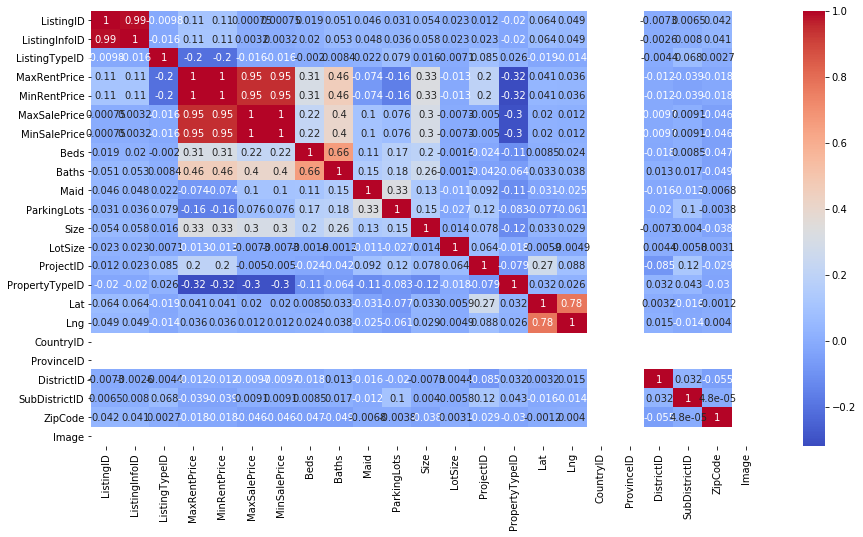

MaxSalePrice      1.000000
MinSalePrice      1.000000
MaxRentPrice      0.946902
MinRentPrice      0.946902
Baths             0.403031
Size              0.300314
Beds              0.219918
Maid              0.100415
ParkingLots       0.075952
Lat               0.020311
Lng               0.012488
SubDistrictID     0.009060
ListingInfoID     0.003213
ListingID         0.000750
ProjectID        -0.004959
LotSize          -0.007332
DistrictID       -0.009710
ListingTypeID    -0.016086
ZipCode          -0.045683
PropertyTypeID   -0.298179
CountryID              NaN
ProvinceID             NaN
Image                  NaN
Name: MinSalePrice, dtype: float64

In [6]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')
plt.show()

corr = data.corr()
corr.sort_values(['MinSalePrice'], ascending=False, inplace=True)
corr.MinSalePrice

# Load Clean Data

In [4]:
data = pd.read_csv('02_data_with_avg_saleprice.csv',delimiter=',') 
data = data[data['MinSalePrice']>500000]
data = data[data['MinSalePrice']<100000000]



data['AvgDistrict'] = data['MinSalePrice'].groupby(data['SubDistrictNameEN']).transform(np.mean)
data.head(5)

,Unnamed: 0,Unnamed: 0.1,ListingID,ListingInfoID,ListingTypeID,BuildingNameTH,MaxRentPrice,MinRentPrice,MaxSalePrice,MinSalePrice,...,ProvinceNameTH,ProvinceNameEN,CountryNameEN,Image,Ave_MinSalePrice,AvgDistrict,highway,Starbucks,shop.,transport
0,0,0,110053340,1100053070,1,NaN,5000000.0,5000000.0,5000000.0,5000000.0,...,กรุงเทพ,Bangkok,Thailand,1.0,2.238314e+07,7.063194e+06,123,22,21,10
1,1,1,100500412,1005004121,1,NaN,NaN,NaN,23000000.0,23000000.0,...,กรุงเทพ,Bangkok,Thailand,NaN,2.402647e+07,2.558217e+07,178,27,20,11
2,2,2,100100069,1001000691,1,NaN,NaN,NaN,2350000.0,2350000.0,...,กรุงเทพ,Bangkok,Thailand,1.0,6.170836e+06,5.459535e+06,0,0,0,0
3,3,3,110025306,1100025175,1,NaN,NaN,NaN,15000000.0,15000000.0,...,กรุงเทพ,Bangkok,Thailand,1.0,7.867966e+06,1.076100e+07,8,0,2,1
4,4,4,110039244,1100039089,1,NaN,NaN,NaN,16000000.0,16000000.0,...,กรุงเทพ,Bangkok,Thailand,NaN,2.342973e+07,NaN,101,4,25,6


# splits trian test

In [8]:
columns = ['Baths','Beds','Size','LotSize','Maid','ParkingLots','SubDistrictID','AvgDistrict','Lat','Lng','ListingInfoID','ListingID','ProjectID','DistrictID','ZipCode','Ave_MinSalePrice','highway','Starbucks','shop.','transport']
x = pd.DataFrame(data, columns=columns)
y = pd.DataFrame(data, columns=['MinSalePrice'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=4452)
X_train.head()

,Baths,Beds,Size,LotSize,Maid,ParkingLots,SubDistrictID,AvgDistrict,Lat,Lng,ListingInfoID,ListingID,ProjectID,DistrictID,ZipCode,Ave_MinSalePrice,highway,Starbucks,shop.,transport
4174,2,3,140.0,73.0,0,0,84.0,8.261359e+06,14.013750,100.871448,1100038976,110039131,NaN,28.0,10250.0,8.090000e+06,0,0,0,0
3584,2,3,0.0,22.0,0,1,32.0,1.659250e+07,13.808242,100.426240,1100039405,110039562,NaN,10.0,10170.0,6.318750e+06,10,0,0,0
2050,2,3,0.0,55.1,0,2,145.0,8.231989e+06,13.909405,100.679702,1004012281,100401228,NaN,46.0,10220.0,6.954107e+06,0,0,3,2
169,3,3,0.0,31.2,0,3,84.0,8.261359e+06,13.680909,100.706112,1100022998,110023129,NaN,28.0,10250.0,9.205135e+06,0,0,0,0
3502,6,6,0.0,139.0,0,0,35.0,2.026450e+07,13.774635,100.415953,1100001750,110001829,NaN,10.0,10170.0,2.165636e+07,0,1,3,0


# Utilize GridSearch for tuning hyperparameters of XGBoost

In [9]:
from sklearn.model_selection import GridSearchCV

xgb_model = XGBRegressor()

parameters = {'learning_rate': [0.01, 0.007],
              'max_depth': [3, 5, 7,10],
              'min_child_weight': [2, 4, 7],
              'n_estimators': [120, 150],
              }

grid = GridSearchCV(xgb_model,parameters,cv=5,scoring=custom_scorer)


grid.fit(X_train, y_train, early_stopping_rounds=5,
             eval_set=[(X_test, y_test)], verbose=0)

xgb_model = grid.best_estimator_

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=666)

scores = cross_val_score(xgb_model, X_train, y_train, cv=cv,scoring=custom_scorer)
print("MAPE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

[10:30:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:40] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:30:43] WARNI

[10:31:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:31:18] WARNI

[10:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:32:20] WARNI

[10:33:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:05] WARNI

[10:33:49] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:55] WARNI

# plot the error for each price range

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Text(0.5, 0, 'segment')

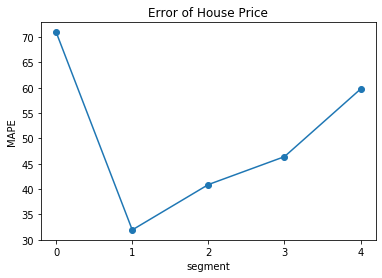

In [10]:
y_pred = xgb_model.predict(X_test)

answer = y_test
mape = ((abs(answer['MinSalePrice'] - y_pred))/answer['MinSalePrice'])*100

answer['Prediction'] = y_pred
answer['Error'] = mape

segment_1 = answer['Error'][answer['MinSalePrice']<=3000000].mean()
segment_2 = answer['Error'][answer['MinSalePrice']>3000000][answer['MinSalePrice']<=6000000].mean()
segment_3 = answer['Error'][answer['MinSalePrice']>6000000][answer['MinSalePrice']<=10000000].mean()
segment_4 = answer['Error'][answer['MinSalePrice']>10000000][answer['MinSalePrice']<=20000000].mean()
segment_5 = answer['Error'][answer['MinSalePrice']>20000000].mean()
lis = [segment_1, segment_2, segment_3, segment_4,segment_5]
plt.plot(lis,marker = 'o')
plt.xticks([0,1,2,3,4])
plt.title('Error of House Price')
plt.ylabel('MAPE')
plt.xlabel('segment')

# CNN

# Read Image

In [12]:
import os
import cv2
import numpy as np
from collections import deque

train = []
inputImage = cv2.imread("./02_image/100500412")
train.append(inputImage)
train.append(inputImage)
train = np.array(train)

#read files
train =  np.zeros((5000,224, 224, 3),dtype=np.float32)
label = []
n=0
a= 0

lisid = []
for root ,dirs,files in os.walk("./02_image/") :
     
     for i in files:
        
        if i.endswith('.jpg'):
            
            try:
                label.append(data.loc[data['ListingID']==int(i[:-4])]['MinSalePrice'].values[0])
                lisid.append(int(i[:-4]))
                inputImage = cv2.imread("./02_image/"+i)
                inputImage =inputImage/255.
                train[n] = inputImage
                n=n+1
                
            except:
                a=0
        if(n%2000==0):
            #break
            print(n)

0
0
2000


# show Image

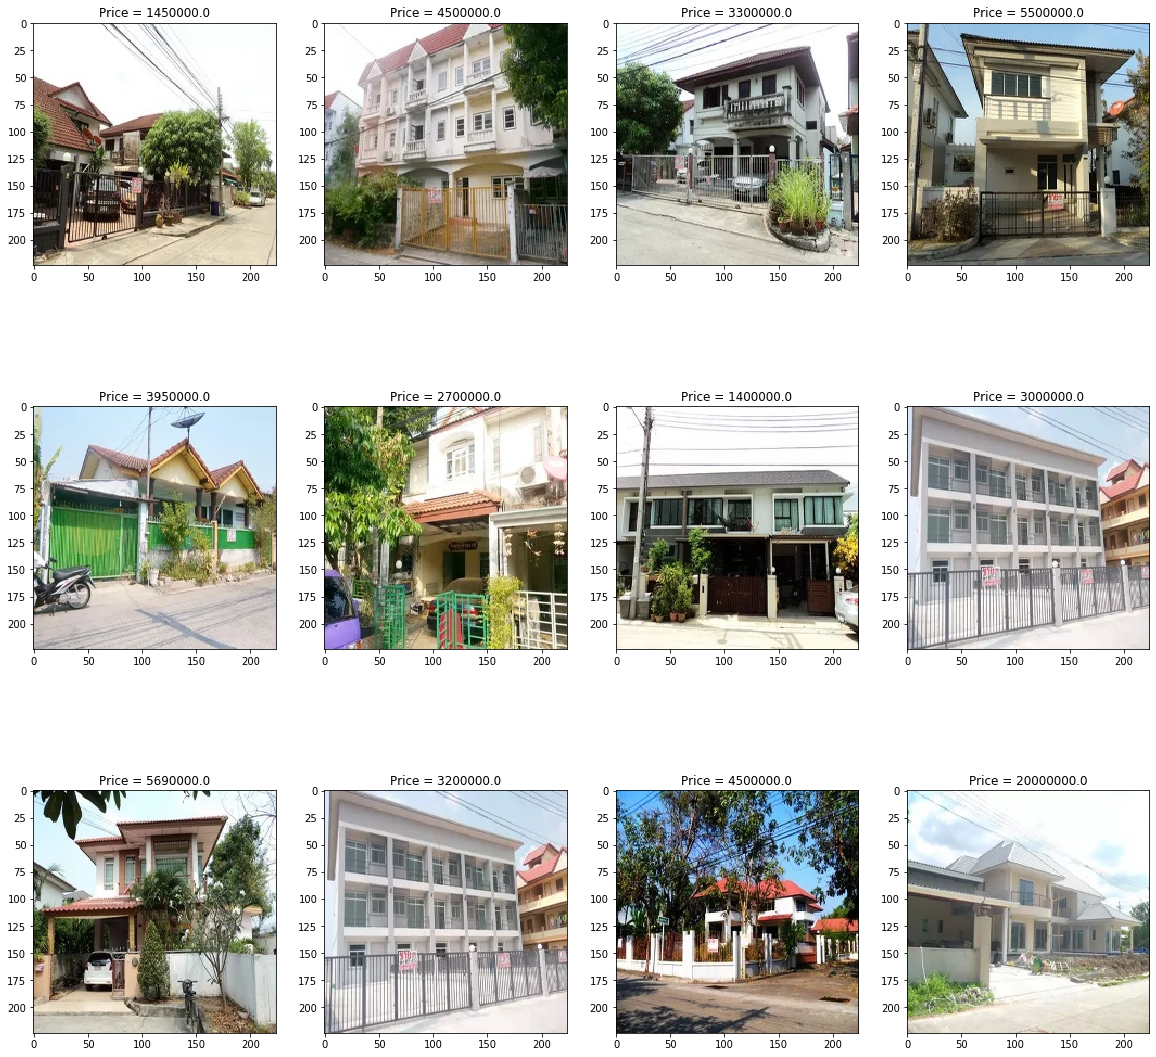

In [13]:
example_image = []
lisid2 = []
label2 = []
for root ,dirs,files in os.walk("./02_image/") :    
     for i in files:
        if i.endswith('.jpg'):
            n=n+1
            try:
                label2.append(data.loc[data['ListingID']==int(i[:-4])]['MinSalePrice'].values[0])
                lisid2.append(int(i[:-4]))
                inputImage = cv2.imread("./02_image/"+i)
                example_image.append(inputImage)
            except:
                a=0
        if(n==12):
            break          
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 3
ax = []
for i in range(columns*rows):
    img = np.random.randint(10, size=(h,w))
    ax.append(fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Price = "+str(label2[i]))  # set title
    plt.imshow(cv2.cvtColor(example_image[i+1], cv2.COLOR_BGR2RGB))
plt.show()

# Labeling the images

In [14]:
l = []
label_class = []
train_2class = []
n=0
for i in range(len(label)):

    if(label[i]<=4000000):
        label_class.append('L')
        l.append(label[i])
        train_2class.append(train[i])
        n=n+1
        
    elif(label[i]>7000000 ):
        label_class.append('H')
        l.append(label[i])
        train_2class.append(train[i])
             

# vgg19 Model

In [14]:
import keras
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from sklearn.metrics import accuracy_score
img_rows, img_cols, img_channel = 224, 224, 3
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16, VGG19


#base_model = applications.VGG16(include_top=True, input_shape=(img_rows, img_cols, img_channel))
#base_model =  VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
#base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))
#vgg_conv = VGG16(weights='imagenet', include_top = True, input_shape=(224, 224, 3))

#baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model = applications.VGG16(include_top=True, input_shape=(img_rows, img_cols, img_channel))


no_feature = 5

base_model.layers.pop()
out = Dense(128, activation='relu')(base_model.layers[-1].output)
out = Dense(no_feature,activation = 'linear')(out)
outsoftmax = Dense(2,activation = 'softmax')(out)
model2 = Model(base_model.input,outsoftmax)
model2.summary()

model2.compile(loss="binary_crossentropy", optimizer=optimizers.SGD(lr=1e-4,decay=0.1), metrics=['accuracy'])

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________

# splits data for CNN

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(label_class)
encoded_Y = encoder.transform(label_class)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

y = dummy_y
train_2class = np.array(train_2class,dtype=np.float32)

x_train, x_test, y_train, y_test = train_test_split(train_2class, y, test_size=0.25, random_state=888)

# CNN training

In [ ]:
# train data
# ImageDataGenerator is augmentation of image 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
batch_size = 64
epochs = 3



train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        )
train_datagen.fit(x_train)


history = cnn_model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    #callbacks=[ModelCheckpoint('vgg_nofreeze.h5', monitor='val_acc', save_best_only=True),tbCallBack]
)

# Test image

In [15]:
#read file image
#normalize image by devide 255
#create train data set by append each image in list
#create Salesprice of each house in form of list (label)
import os
import cv2

test = []
label2 = []
n=0
a= 0
lisid2 = []
for root ,dirs,files in os.walk("./02_image/") :
     
     for i in files:
        
        if i.endswith('.jpg'):
            n=n+1
            try:
                label2.append(data.loc[data['ListingID']==int(i[:-4])]['SalePrice'].values[0])
                
                
                
            except:
                inputImage = cv2.imread("./02_image/"+i)
                
                inputImage =inputImage/255.
                test.append(inputImage)
                lisid2.append(int(i[:-4]))
                a=a+1
        if(n%200==0):
            #break
            print(n)

200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600


# Load Weights from Lastest Training

In [17]:
test_model = applications.VGG16(include_top=True, input_shape=(img_rows, img_cols, img_channel))


no_feature = 5

test_model.layers.pop()
out = Dense(128, activation='relu')(test_model.layers[-1].output)
out = Dense(no_feature,activation = 'linear')(out)
#outsoftmax = Dense(2,activation = 'softmax')(out)
model3 = Model(test_model.input,out)
model3.summary()
model3.load_weights('for_win_test.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# Predicts test set with CNN

In [20]:
test = np.array(test,dtype=np.float32)
#predict features
y_pred = model3.predict(test)
y_pred

array([[-0.84092695, -0.49544653, -0.14956336, -0.7581821 , -0.08542281],
       [-0.83304596, -0.63512915, -0.10290042, -0.78758025, -0.26953346],
       [-0.6770312 , -0.39672053, -0.04461467, -0.7678367 , -0.04705611],
       ...,
       [-0.7996656 , -0.5549082 , -0.16434692, -0.89752567, -0.21600059],
       [-0.87031835, -0.5390056 , -0.02377152, -0.70297295, -0.10786088],
       [-0.75383186, -0.55967474, -0.01580652, -0.6275118 , -0.27737373]],
      dtype=float32)

# Predicted Result

In [21]:
feature = pd.DataFrame({'ListingID':lisid2[:],'f1':y_pred[:,0],'f2':y_pred[:,1],'f3':y_pred[:,2],'f4':y_pred[:,3]
                       ,'f5':y_pred[:,4]})
feature.head(10)

,ListingID,f1,f2,f3,f4,f5
0,100100020,-0.840927,-0.495447,-0.149563,-0.758182,-0.085423
1,100100021,-0.833046,-0.635129,-0.102900,-0.787580,-0.269533
2,100100024,-0.677031,-0.396721,-0.044615,-0.767837,-0.047056
3,100100027,-0.960205,-0.388206,-0.295090,-0.836419,-0.275987
4,100100029,-0.933996,-0.241611,-0.153034,-0.871821,-0.135012
5,100100031,-0.893463,-0.687716,-0.266357,-0.647562,0.171367
6,100100032,-0.883352,-0.556575,-0.164596,-0.768629,-0.276067
7,100100034,-0.858306,-0.489745,-0.074173,-0.894156,-0.112953
8,100100035,-0.844829,-0.706052,-0.140396,-0.810272,-0.170799
9,100100038,-1.082571,-0.473849,-0.127781,-0.850289,-0.283714


# Load test data

In [5]:
#datatest  = pd.read_csv('./Testset_Homedottech_Hackathon.csv', encoding='utf8')
datatest  = pd.read_csv('./02_datatest_with_avg_saleprice.csv', encoding='utf8')
datatest = datatest[datatest['MinSalePrice']>500000]
datatest = datatest[datatest['MinSalePrice']<100000000]
datatest.head(3)

,Unnamed: 0,ListingID,ListingInfoID,ListingTypeID,BuildingNameTH,MaxRentPrice,MinRentPrice,MaxSalePrice,MinSalePrice,Beds,...,ProvinceNameTH,ProvinceNameEN,CountryNameEN,Image,highway,Starbucks,shop.,transport,AvgDistrict,Ave_MinSalePrice
0,0,100100048,1001000481,1,NaN,NaN,NaN,1750000.0,1750000.0,3,...,กรุงเทพ,Bangkok,Thailand,1.0,0,0,0,0,7.900000e+06,4.788255e+06
1,1,110004914,1100004831,1,NaN,NaN,NaN,2300000.0,2300000.0,3,...,กรุงเทพ,Bangkok,Thailand,1.0,2,0,0,0,5.413750e+06,5.217000e+06
2,2,110007601,1100007518,1,NaN,NaN,NaN,3500000.0,3500000.0,6,...,กรุงเทพ,Bangkok,Thailand,1.0,0,0,1,2,8.297778e+06,3.256923e+06


In [30]:
columns = ['ListingID','AvgDistrict','Ave_MinSalePrice','LotSize','ParkingLots','Baths','Beds','highway','shop.','Starbucks','MinSalePrice','DistrictID','transport']
columns = ['LotSize','Baths','Beds','ParkingLots','Size','DistrictID','ListingID','AvgDistrict','Ave_MinSalePrice','MinSalePrice']
x = pd.DataFrame(datatest, columns=columns)

new_y = x['MinSalePrice']
del x['MinSalePrice']

new_x = x.merge(feature, on='ListingID', how='left')
del new_x['ListingID']

new_x.head(5)

,LotSize,Baths,Beds,ParkingLots,Size,DistrictID,AvgDistrict,Ave_MinSalePrice,f1,f2,f3,f4,f5
0,24.0,2,3,0,0.0,3.0,7.900000e+06,4.788255e+06,-0.971222,-0.496881,-0.094034,-1.018302,-0.199725
1,18.0,2,3,1,116.0,20.0,5.413750e+06,5.217000e+06,-0.915893,-0.451721,-0.058963,-0.809579,-0.195949
2,64.0,4,6,0,200.0,38.0,8.297778e+06,3.256923e+06,-0.799467,-0.721454,-0.089888,-0.588466,0.029808
3,64.0,3,3,2,194.0,7.0,4.083846e+06,4.606465e+06,-0.716967,-0.696018,-0.021803,-0.640396,-0.116578
4,0.0,3,4,0,0.0,NaN,NaN,1.642727e+07,NaN,NaN,NaN,NaN,NaN


# Test with XGBoost

In [31]:
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.25, random_state=4452)
X_train.head()

xgb_model = XGBRegressor()

parameters = {'learning_rate': [0.01, 0.007],
              'max_depth': [3, 5, 7,10],
              'min_child_weight': [2, 4, 7],
              'n_estimators': [120, 150],
              }

grid = GridSearchCV(xgb_model,parameters,cv=5,scoring=custom_scorer)


grid.fit(X_train, y_train, early_stopping_rounds=5,
             eval_set=[(X_test, y_test)], verbose=0)

xgb_model = grid.best_estimator_

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=666)

scores = cross_val_score(xgb_model, X_train, y_train, cv=cv,scoring=custom_scorer)
print("MAPE: %0.2f (+/- %0.2f)" % (-scores.mean(), scores.std() * 2))

[12:14:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:21] WARNI

[12:14:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:14:37] WARNI

[12:15:02] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:03] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:06] WARNI

[12:15:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:24] WARNI

[12:15:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:15:49] WARNI

# Prediction

Text(0.5, 0, 'segment')

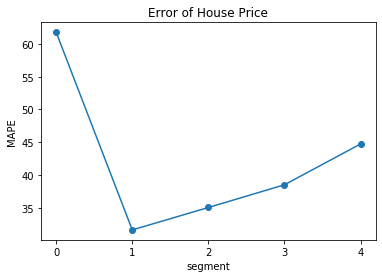

In [34]:
y_pred = xgb_model.predict(X_test)

answer = pd.DataFrame(y_test, columns=['MinSalePrice'])
mape = ((abs(answer['MinSalePrice'] - y_pred))/answer['MinSalePrice'])*100

answer['Prediction'] = y_pred
answer['Error'] = mape

segment_1 = answer['Error'][answer['MinSalePrice']<=3000000].mean()
segment_2 = answer['Error'][answer['MinSalePrice']>3000000][answer['MinSalePrice']<=6000000].mean()
segment_3 = answer['Error'][answer['MinSalePrice']>6000000][answer['MinSalePrice']<=10000000].mean()
segment_4 = answer['Error'][answer['MinSalePrice']>10000000][answer['MinSalePrice']<=20000000].mean()
segment_5 = answer['Error'][answer['MinSalePrice']>20000000].mean()
lis = [segment_1, segment_2, segment_3, segment_4,segment_5]
plt.plot(lis,marker = 'o')
plt.xticks([0,1,2,3,4])
plt.title('Error of House Price')
plt.ylabel('MAPE')
plt.xlabel('segment')